In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

## Examine data

In [2]:
%%capture
df = pd.read_csv('clinvar_20180225.ann.tsv.gz', compression='gzip', sep='\t', error_bad_lines=False, header=0)

In [3]:
len(df)

372159

In [4]:
df.head()

,#id,chrom,inputPos,inputRef,inputAlt,unannotatedReason,gene,geneId,geneDesc,transcript,...,granthamDist,AGVGDclass,AGVGDgv,AGVGDgd,SIFTprediction,SIFTweight,SIFTmedian,MAPPprediction,MAPPpValue,MAPPpValueMedian
0,475283,1,949422,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,178.468,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,183381,1,949523,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,475278,1,949597,C,T,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,402986,1,949608,G,A,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,46.0,C0,130.977,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,161455,1,949696,C,CG,-,ISG15,4053,ISG15 ubiquitin-like modifier,NM_005101.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

#id                       int64
chrom                    object
inputPos                  int64
inputRef                 object
inputAlt                 object
unannotatedReason        object
gene                     object
geneId                    int64
geneDesc                 object
transcript               object
strand                    int64
transLen                  int64
cdsLen                    int64
protein                  object
Uniprot                  object
varType                  object
codingEffect             object
varLocation              object
assembly                 object
gDNAstart                 int64
gDNAend                   int64
gNomen                   object
cDNAstart                object
cDNAend                  object
cNomen                   object
pNomen                   object
alt_pNomen               object
exon                      int64
intron                  float64
omimId                  float64
                         ...   
wtAA_3  

In [6]:
df.isnull().sum()

#id                          0
chrom                        0
inputPos                     0
inputRef                     0
inputAlt                     0
unannotatedReason            0
gene                         0
geneId                       0
geneDesc                     0
transcript                   0
strand                       0
transLen                     0
cdsLen                       0
protein                  16608
Uniprot                  88433
varType                      0
codingEffect            131716
varLocation                  0
assembly                     0
gDNAstart                    0
gDNAend                      0
gNomen                       0
cDNAstart                    0
cDNAend                      0
cNomen                       0
pNomen                    2380
alt_pNomen                2380
exon                         0
intron                  318115
omimId                   21182
                         ...  
wtAA_3                  158696
wtCodon 

## Preprocessing

### Filters

In [7]:
RELEVANT_FEATURES = [
    'chrom',
    'inputPos',
    'inputRef',
    'inputAlt',
    'transcript',
    'codingEffect',
    'varLocation',
    'alt_pNomen',
    'wtSSFScore',
    'wtMaxEntScore',
    'varSSFScore',
    'varMaxEntScore',
#     'rsId',
#     'rsClinicalSignificance',
    'rsMAF',
    '1000g_AF',
    'gnomadAltFreq_all',
    'espAllMAF',
    'espAllAAF',
    'clinVarMethods',
    'clinVarClinSignifs',
    'nOrthos',
    'conservedOrthos'
]


RULES = [
    lambda df: df['codingEffect'] != 'synonymous',
    lambda df: df['varLocation'] != 'intron',
    lambda df: np.invert(df['1000g_AF'] > 0.01),
    lambda df: np.invert(df['gnomadAltFreq_all'] > 0.01)
]


def rules_filter(df):
    for rule in RULES:
        df = df[rule(df)]
    return df


df = df[RELEVANT_FEATURES]  # Filtering relevant features
df = rules_filter(df)  # Rules filtering
df.reset_index(drop=True, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,varMaxEntScore,rsMAF,1000g_AF,gnomadAltFreq_all,espAllMAF,espAllAAF,clinVarMethods,clinVarClinSignifs,nOrthos,conservedOrthos
0,1,949422,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,7.04863,0.006190,0.006190,0.001599,0.005459,0.005459,NaN,NaN,10.0,2.0
1,1,949523,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
2,1,949696,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,7.04863,0.000000,NaN,NaN,NaN,NaN,literature only,Pathogenic,NaN,NaN
3,1,949739,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,7.04863,0.000000,NaN,0.000008,NaN,NaN,literature only,Pathogenic,NaN,NaN
4,1,949851,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,7.04863,0.000799,0.000799,0.000265,0.000698,0.000698,NaN,NaN,10.0,2.0


### `inputPos` as regression parametr

In [8]:
df.inputPos = df.inputPos.astype(float)

### `clinVarMethods` split

In [9]:
def fetch_names(row, delimeters='|,'):
    def unify(name):
        return '_'.join(name.strip().lower().split())
    
    names = [row]
    for delimeter in delimeters:
        new_names = []
        for name in names:
            new_names.extend(name.split(delimeter))
        names = new_names
    return [unify(name) for name in names]


def collect_names(column, delimeters='|,'): 
    all_names = set()
    for row in column:
        all_names.update(set(fetch_names(row)))
    return all_names

In [10]:
df.clinVarMethods = df.clinVarMethods.fillna('NaN')
cvm_methods = {m: i for i, m in enumerate(list(collect_names(df.clinVarMethods)))}
cvm_features = []
for row in df.clinVarMethods:
    row_features = np.zeros(len(cvm_methods))
    for name in fetch_names(row):
        row_features[cvm_methods[name]] += 1
    cvm_features.append(row_features)
cvm_features = np.vstack(cvm_features)

cvm_columns = ['cvm_' + m for _, m in sorted([(i, m) for m, i in cvm_methods.items()])]
cvm_features = pd.DataFrame(cvm_features, columns=cvm_columns)
df = pd.concat([df, cvm_features], axis=1)
del df['clinVarMethods']
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_reference_population,cvm_in_vivo,cvm_not_provided,cvm_in_vitro,cvm_phenotyping_only,cvm_clinical_testing,cvm_curation,cvm_research,cvm_case-control,cvm_nan
0,1,949422.0,G,A,NM_005101.3,missense,exon,p.Ser21Asn,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,949851.0,G,C,NM_005101.3,missense,exon,p.Arg164Pro,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Making target

In [11]:
def binarize_target(y, bad_word='pathogenic'):
    return y.apply(lambda x: int(bad_word in x.lower()))

In [12]:
df = df.loc[df.clinVarClinSignifs.notna()]
df.reset_index(drop=True, inplace=True)
df.rename({'clinVarClinSignifs': 'y'}, axis=1, inplace=True)
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_reference_population,cvm_in_vivo,cvm_not_provided,cvm_in_vitro,cvm_phenotyping_only,cvm_clinical_testing,cvm_curation,cvm_research,cvm_case-control,cvm_nan
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## TT split

In [13]:
def tt_split(df):
    np.random.seed(42)
    df = df.copy()
    
    y = binarize_target(df.y)
    del df['y']
    X = df
    
    X = X.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
    X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, test_size=0.2)
    
    cat_features = np.where(X.dtypes != np.float)[0]

    return (X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features

## NDCG

In [14]:
relevances = {'benign': 0, 'likely benign': 1, 'not provided': 2, 'vus': 2, 'likely pathogenic': 3, 'pathogenic': 4}


def split_relevance(relevance):
    return [r.lower() for it in relevance.split('|') for r in it.split(', ') if r.lower() in relevances]


def get_relevances(significances):
    return [split_relevance(significance) for significance in significances.values]


def dcg(relevances):
    return np.sum(2 ** relevances / np.log2(np.arange(2, relevances.size + 2)))


def evaluate_serp(df, sign, score, n=30):
    serp = df.sample(n=n, replace=False)
    rel_true = np.array([relevances[np.random.choice(sign[index], size=1)[0]] for index, row in serp.iterrows()])

    order_true = np.argsort(rel_true)[::-1]
    serp = serp.iloc[order_true]
    rel_true = rel_true[order_true]

    order_pred = np.argsort(score[serp.index])[::-1]
    rel_pred = rel_true[order_pred]
    
    return dcg(rel_pred) / dcg(rel_true)


def evaluate(df, sign, score, k=1000, n=30):
    np.random.seed(42)
    return np.mean([evaluate_serp(df, sign, score, n) for _ in range(k)])

In [15]:
sign = pd.Series(data=get_relevances(df.y), index=df.index)
not_empty = [it != [] for it in sign]
df = df[not_empty]
sign = sign[not_empty]
df.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_reference_population,cvm_in_vivo,cvm_not_provided,cvm_in_vitro,cvm_phenotyping_only,cvm_clinical_testing,cvm_curation,cvm_research,cvm_case-control,cvm_nan
0,1,949523.0,C,T,NM_005101.3,stop gain,exon,p.Gln55*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,949696.0,C,CG,NM_005101.3,frameshift,exon,p.Leu114Alafs*?,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,949739.0,G,T,NM_005101.3,stop gain,exon,p.Glu127*,80.7048,7.04863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,955563.0,G,C,NM_001305275.1,missense,exon,p.Arg4Pro,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,955596.0,C,G,NM_001305275.1,missense,exon,p.Pro15Arg,78.7671,9.04567,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Run

In [16]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test), cat_features = tt_split(df)
len(X_train), len(X_validate), len(X_test)

(126179, 31545, 39431)

In [17]:
model = CatBoostClassifier()

In [18]:
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_validate, y_validate));

0:	learn: 0.6637269	test: 0.6635160	best: 0.6635160 (0)	total: 313ms	remaining: 5m 12s
1:	learn: 0.6359497	test: 0.6357103	best: 0.6357103 (1)	total: 585ms	remaining: 4m 51s
2:	learn: 0.6115357	test: 0.6110220	best: 0.6110220 (2)	total: 772ms	remaining: 4m 16s
3:	learn: 0.5897249	test: 0.5889593	best: 0.5889593 (3)	total: 1.01s	remaining: 4m 10s
4:	learn: 0.5681708	test: 0.5672307	best: 0.5672307 (4)	total: 1.15s	remaining: 3m 49s
5:	learn: 0.5445984	test: 0.5433213	best: 0.5433213 (5)	total: 1.36s	remaining: 3m 45s
6:	learn: 0.5226122	test: 0.5203563	best: 0.5203563 (6)	total: 1.64s	remaining: 3m 52s
7:	learn: 0.5024710	test: 0.4993298	best: 0.4993298 (7)	total: 1.87s	remaining: 3m 51s
8:	learn: 0.4838602	test: 0.4802571	best: 0.4802571 (8)	total: 2.12s	remaining: 3m 53s
9:	learn: 0.4664336	test: 0.4623143	best: 0.4623143 (9)	total: 2.38s	remaining: 3m 55s
10:	learn: 0.4499570	test: 0.4448718	best: 0.4448718 (10)	total: 2.55s	remaining: 3m 49s
11:	learn: 0.4360517	test: 0.4302910	best

93:	learn: 0.2176035	test: 0.2058987	best: 0.2058987 (93)	total: 22.9s	remaining: 3m 40s
94:	learn: 0.2170639	test: 0.2053487	best: 0.2053487 (94)	total: 23.2s	remaining: 3m 40s
95:	learn: 0.2165597	test: 0.2048344	best: 0.2048344 (95)	total: 23.3s	remaining: 3m 39s
96:	learn: 0.2161072	test: 0.2043886	best: 0.2043886 (96)	total: 23.6s	remaining: 3m 39s
97:	learn: 0.2158358	test: 0.2041742	best: 0.2041742 (97)	total: 23.9s	remaining: 3m 39s
98:	learn: 0.2153086	test: 0.2035839	best: 0.2035839 (98)	total: 24.2s	remaining: 3m 40s
99:	learn: 0.2149366	test: 0.2032262	best: 0.2032262 (99)	total: 24.4s	remaining: 3m 40s
100:	learn: 0.2145029	test: 0.2028586	best: 0.2028586 (100)	total: 24.7s	remaining: 3m 40s
101:	learn: 0.2140951	test: 0.2024114	best: 0.2024114 (101)	total: 25.1s	remaining: 3m 40s
102:	learn: 0.2138039	test: 0.2021504	best: 0.2021504 (102)	total: 25.4s	remaining: 3m 40s
103:	learn: 0.2135049	test: 0.2018861	best: 0.2018861 (103)	total: 25.6s	remaining: 3m 40s
104:	learn: 0

185:	learn: 0.1951898	test: 0.1848846	best: 0.1848846 (185)	total: 48.7s	remaining: 3m 33s
186:	learn: 0.1950850	test: 0.1848085	best: 0.1848085 (186)	total: 49s	remaining: 3m 33s
187:	learn: 0.1950175	test: 0.1847448	best: 0.1847448 (187)	total: 49.3s	remaining: 3m 32s
188:	learn: 0.1948891	test: 0.1846460	best: 0.1846460 (188)	total: 49.6s	remaining: 3m 32s
189:	learn: 0.1947730	test: 0.1845512	best: 0.1845512 (189)	total: 49.9s	remaining: 3m 32s
190:	learn: 0.1945818	test: 0.1843982	best: 0.1843982 (190)	total: 50.2s	remaining: 3m 32s
191:	learn: 0.1944629	test: 0.1842871	best: 0.1842871 (191)	total: 50.5s	remaining: 3m 32s
192:	learn: 0.1944101	test: 0.1842476	best: 0.1842476 (192)	total: 50.8s	remaining: 3m 32s
193:	learn: 0.1941602	test: 0.1839984	best: 0.1839984 (193)	total: 51.1s	remaining: 3m 32s
194:	learn: 0.1940811	test: 0.1839466	best: 0.1839466 (194)	total: 51.3s	remaining: 3m 31s
195:	learn: 0.1940039	test: 0.1838625	best: 0.1838625 (195)	total: 51.6s	remaining: 3m 31s
1

276:	learn: 0.1865173	test: 0.1773605	best: 0.1773605 (276)	total: 1m 14s	remaining: 3m 13s
277:	learn: 0.1864323	test: 0.1772893	best: 0.1772893 (277)	total: 1m 14s	remaining: 3m 13s
278:	learn: 0.1863656	test: 0.1772352	best: 0.1772352 (278)	total: 1m 14s	remaining: 3m 12s
279:	learn: 0.1863027	test: 0.1771879	best: 0.1771879 (279)	total: 1m 14s	remaining: 3m 12s
280:	learn: 0.1862448	test: 0.1771298	best: 0.1771298 (280)	total: 1m 15s	remaining: 3m 12s
281:	learn: 0.1861224	test: 0.1770272	best: 0.1770272 (281)	total: 1m 15s	remaining: 3m 12s
282:	learn: 0.1860709	test: 0.1769798	best: 0.1769798 (282)	total: 1m 15s	remaining: 3m 11s
283:	learn: 0.1860193	test: 0.1769473	best: 0.1769473 (283)	total: 1m 15s	remaining: 3m 11s
284:	learn: 0.1859279	test: 0.1768925	best: 0.1768925 (284)	total: 1m 16s	remaining: 3m 11s
285:	learn: 0.1857957	test: 0.1767679	best: 0.1767679 (285)	total: 1m 16s	remaining: 3m 11s
286:	learn: 0.1857341	test: 0.1767243	best: 0.1767243 (286)	total: 1m 16s	remain

366:	learn: 0.1816542	test: 0.1734115	best: 0.1734115 (366)	total: 1m 39s	remaining: 2m 52s
367:	learn: 0.1816092	test: 0.1733745	best: 0.1733745 (367)	total: 1m 40s	remaining: 2m 52s
368:	learn: 0.1815912	test: 0.1733670	best: 0.1733670 (368)	total: 1m 40s	remaining: 2m 51s
369:	learn: 0.1815642	test: 0.1733416	best: 0.1733416 (369)	total: 1m 40s	remaining: 2m 51s
370:	learn: 0.1815416	test: 0.1733153	best: 0.1733153 (370)	total: 1m 41s	remaining: 2m 51s
371:	learn: 0.1814511	test: 0.1732301	best: 0.1732301 (371)	total: 1m 41s	remaining: 2m 51s
372:	learn: 0.1813250	test: 0.1731154	best: 0.1731154 (372)	total: 1m 41s	remaining: 2m 50s
373:	learn: 0.1812783	test: 0.1730816	best: 0.1730816 (373)	total: 1m 41s	remaining: 2m 50s
374:	learn: 0.1812527	test: 0.1730656	best: 0.1730656 (374)	total: 1m 42s	remaining: 2m 50s
375:	learn: 0.1812317	test: 0.1730571	best: 0.1730571 (375)	total: 1m 42s	remaining: 2m 50s
376:	learn: 0.1811258	test: 0.1729472	best: 0.1729472 (376)	total: 1m 42s	remain

456:	learn: 0.1778553	test: 0.1704749	best: 0.1704749 (456)	total: 2m 5s	remaining: 2m 28s
457:	learn: 0.1778305	test: 0.1704587	best: 0.1704587 (457)	total: 2m 5s	remaining: 2m 28s
458:	learn: 0.1778157	test: 0.1704512	best: 0.1704512 (458)	total: 2m 5s	remaining: 2m 28s
459:	learn: 0.1778032	test: 0.1704436	best: 0.1704436 (459)	total: 2m 5s	remaining: 2m 27s
460:	learn: 0.1777848	test: 0.1704327	best: 0.1704327 (460)	total: 2m 6s	remaining: 2m 27s
461:	learn: 0.1777571	test: 0.1704209	best: 0.1704209 (461)	total: 2m 6s	remaining: 2m 27s
462:	learn: 0.1777421	test: 0.1704088	best: 0.1704088 (462)	total: 2m 6s	remaining: 2m 26s
463:	learn: 0.1777010	test: 0.1703800	best: 0.1703800 (463)	total: 2m 6s	remaining: 2m 26s
464:	learn: 0.1776776	test: 0.1703596	best: 0.1703596 (464)	total: 2m 7s	remaining: 2m 26s
465:	learn: 0.1776591	test: 0.1703495	best: 0.1703495 (465)	total: 2m 7s	remaining: 2m 26s
466:	learn: 0.1776437	test: 0.1703410	best: 0.1703410 (466)	total: 2m 7s	remaining: 2m 25s

546:	learn: 0.1750879	test: 0.1684960	best: 0.1684960 (546)	total: 2m 30s	remaining: 2m 4s
547:	learn: 0.1750636	test: 0.1684821	best: 0.1684821 (547)	total: 2m 30s	remaining: 2m 4s
548:	learn: 0.1750419	test: 0.1684775	best: 0.1684775 (548)	total: 2m 31s	remaining: 2m 4s
549:	learn: 0.1750258	test: 0.1684732	best: 0.1684732 (549)	total: 2m 31s	remaining: 2m 3s
550:	learn: 0.1750014	test: 0.1684644	best: 0.1684644 (550)	total: 2m 31s	remaining: 2m 3s
551:	learn: 0.1749686	test: 0.1684372	best: 0.1684372 (551)	total: 2m 31s	remaining: 2m 3s
552:	learn: 0.1749517	test: 0.1684349	best: 0.1684349 (552)	total: 2m 32s	remaining: 2m 2s
553:	learn: 0.1749318	test: 0.1684205	best: 0.1684205 (553)	total: 2m 32s	remaining: 2m 2s
554:	learn: 0.1748993	test: 0.1684019	best: 0.1684019 (554)	total: 2m 32s	remaining: 2m 2s
555:	learn: 0.1748874	test: 0.1684031	best: 0.1684019 (554)	total: 2m 32s	remaining: 2m 2s
556:	learn: 0.1748738	test: 0.1683990	best: 0.1683990 (556)	total: 2m 33s	remaining: 2m 1s

636:	learn: 0.1730540	test: 0.1671689	best: 0.1671689 (636)	total: 2m 59s	remaining: 1m 42s
637:	learn: 0.1730503	test: 0.1671655	best: 0.1671655 (637)	total: 2m 59s	remaining: 1m 41s
638:	learn: 0.1730358	test: 0.1671473	best: 0.1671473 (638)	total: 2m 59s	remaining: 1m 41s
639:	learn: 0.1730169	test: 0.1671379	best: 0.1671379 (639)	total: 3m	remaining: 1m 41s
640:	learn: 0.1730044	test: 0.1671231	best: 0.1671231 (640)	total: 3m	remaining: 1m 41s
641:	learn: 0.1729694	test: 0.1670885	best: 0.1670885 (641)	total: 3m	remaining: 1m 40s
642:	learn: 0.1729514	test: 0.1670838	best: 0.1670838 (642)	total: 3m 1s	remaining: 1m 40s
643:	learn: 0.1729101	test: 0.1670566	best: 0.1670566 (643)	total: 3m 1s	remaining: 1m 40s
644:	learn: 0.1728821	test: 0.1670314	best: 0.1670314 (644)	total: 3m 1s	remaining: 1m 39s
645:	learn: 0.1728735	test: 0.1670265	best: 0.1670265 (645)	total: 3m 1s	remaining: 1m 39s
646:	learn: 0.1728484	test: 0.1670205	best: 0.1670205 (646)	total: 3m 2s	remaining: 1m 39s
647:	

726:	learn: 0.1713656	test: 0.1660884	best: 0.1660884 (726)	total: 3m 25s	remaining: 1m 17s
727:	learn: 0.1713521	test: 0.1660805	best: 0.1660805 (727)	total: 3m 25s	remaining: 1m 16s
728:	learn: 0.1713062	test: 0.1660573	best: 0.1660573 (728)	total: 3m 26s	remaining: 1m 16s
729:	learn: 0.1713021	test: 0.1660563	best: 0.1660563 (729)	total: 3m 26s	remaining: 1m 16s
730:	learn: 0.1712900	test: 0.1660443	best: 0.1660443 (730)	total: 3m 26s	remaining: 1m 16s
731:	learn: 0.1712763	test: 0.1660386	best: 0.1660386 (731)	total: 3m 26s	remaining: 1m 15s
732:	learn: 0.1712451	test: 0.1660101	best: 0.1660101 (732)	total: 3m 27s	remaining: 1m 15s
733:	learn: 0.1712364	test: 0.1660064	best: 0.1660064 (733)	total: 3m 27s	remaining: 1m 15s
734:	learn: 0.1711952	test: 0.1659628	best: 0.1659628 (734)	total: 3m 27s	remaining: 1m 14s
735:	learn: 0.1711362	test: 0.1659166	best: 0.1659166 (735)	total: 3m 28s	remaining: 1m 14s
736:	learn: 0.1711234	test: 0.1659150	best: 0.1659150 (736)	total: 3m 28s	remain

816:	learn: 0.1697929	test: 0.1651690	best: 0.1651690 (816)	total: 3m 50s	remaining: 51.7s
817:	learn: 0.1697877	test: 0.1651675	best: 0.1651675 (817)	total: 3m 51s	remaining: 51.4s
818:	learn: 0.1697762	test: 0.1651598	best: 0.1651598 (818)	total: 3m 51s	remaining: 51.2s
819:	learn: 0.1697633	test: 0.1651507	best: 0.1651507 (819)	total: 3m 51s	remaining: 50.9s
820:	learn: 0.1697604	test: 0.1651535	best: 0.1651507 (819)	total: 3m 52s	remaining: 50.6s
821:	learn: 0.1697396	test: 0.1651370	best: 0.1651370 (821)	total: 3m 52s	remaining: 50.3s
822:	learn: 0.1697299	test: 0.1651335	best: 0.1651335 (822)	total: 3m 52s	remaining: 50s
823:	learn: 0.1697278	test: 0.1651335	best: 0.1651335 (822)	total: 3m 53s	remaining: 49.8s
824:	learn: 0.1697056	test: 0.1651088	best: 0.1651088 (824)	total: 3m 53s	remaining: 49.5s
825:	learn: 0.1696980	test: 0.1651103	best: 0.1651088 (824)	total: 3m 53s	remaining: 49.2s
826:	learn: 0.1696630	test: 0.1650818	best: 0.1650818 (826)	total: 3m 53s	remaining: 48.9s
8

907:	learn: 0.1684801	test: 0.1644549	best: 0.1644549 (907)	total: 4m 19s	remaining: 26.3s
908:	learn: 0.1684599	test: 0.1644436	best: 0.1644436 (908)	total: 4m 20s	remaining: 26s
909:	learn: 0.1684506	test: 0.1644346	best: 0.1644346 (909)	total: 4m 20s	remaining: 25.7s
910:	learn: 0.1684235	test: 0.1644192	best: 0.1644192 (910)	total: 4m 20s	remaining: 25.5s
911:	learn: 0.1684023	test: 0.1644023	best: 0.1644023 (911)	total: 4m 20s	remaining: 25.2s
912:	learn: 0.1683977	test: 0.1643967	best: 0.1643967 (912)	total: 4m 21s	remaining: 24.9s
913:	learn: 0.1683810	test: 0.1643946	best: 0.1643946 (913)	total: 4m 21s	remaining: 24.6s
914:	learn: 0.1683621	test: 0.1643891	best: 0.1643891 (914)	total: 4m 21s	remaining: 24.3s
915:	learn: 0.1683540	test: 0.1643905	best: 0.1643891 (914)	total: 4m 22s	remaining: 24s
916:	learn: 0.1683452	test: 0.1643900	best: 0.1643891 (914)	total: 4m 22s	remaining: 23.7s
917:	learn: 0.1683339	test: 0.1643852	best: 0.1643852 (917)	total: 4m 22s	remaining: 23.5s
918

998:	learn: 0.1673735	test: 0.1638428	best: 0.1638428 (998)	total: 4m 46s	remaining: 286ms
999:	learn: 0.1673636	test: 0.1638309	best: 0.1638309 (999)	total: 4m 46s	remaining: 0us

bestTest = 0.1638308522
bestIteration = 999

Shrink model to first 1000 iterations.


In [19]:
y_pred = model.predict(X_test)
(y_pred == y_test).sum() / len(y_test)

0.9350764626816465

In [20]:
score = pd.Series(data=y_pred, index=X_test.index)
evaluate(X_test, sign, score)

0.9611025561189052

## Analysis

In [21]:
def draw_importance(columns, importances):
    order = np.argsort(importances)
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    plt.show()

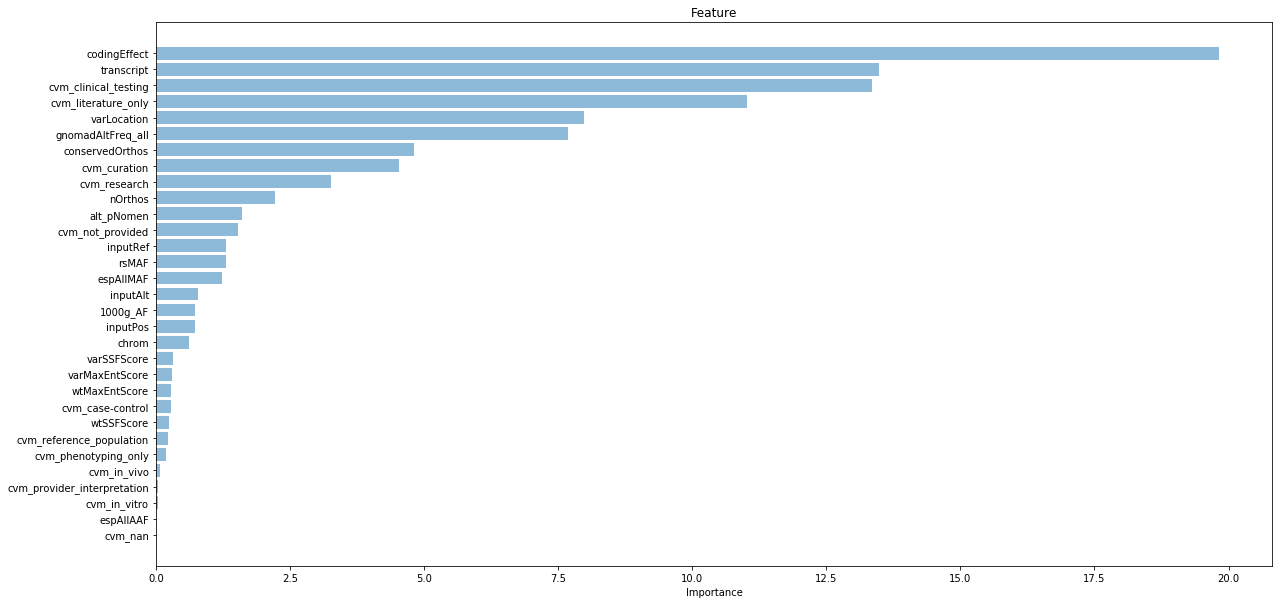

In [22]:
draw_importance(X_train.columns, model.feature_importances_)